In [2]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [3]:
newsgroups = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)
df = pd.DataFrame({'text': newsgroups.data, 'target': newsgroups.target})
df.head()

,text,target
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4


In [4]:
df['target_name'] = df['target'].apply(lambda x: newsgroups.target_names[x])
df.head()

,text,target,target_name
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware


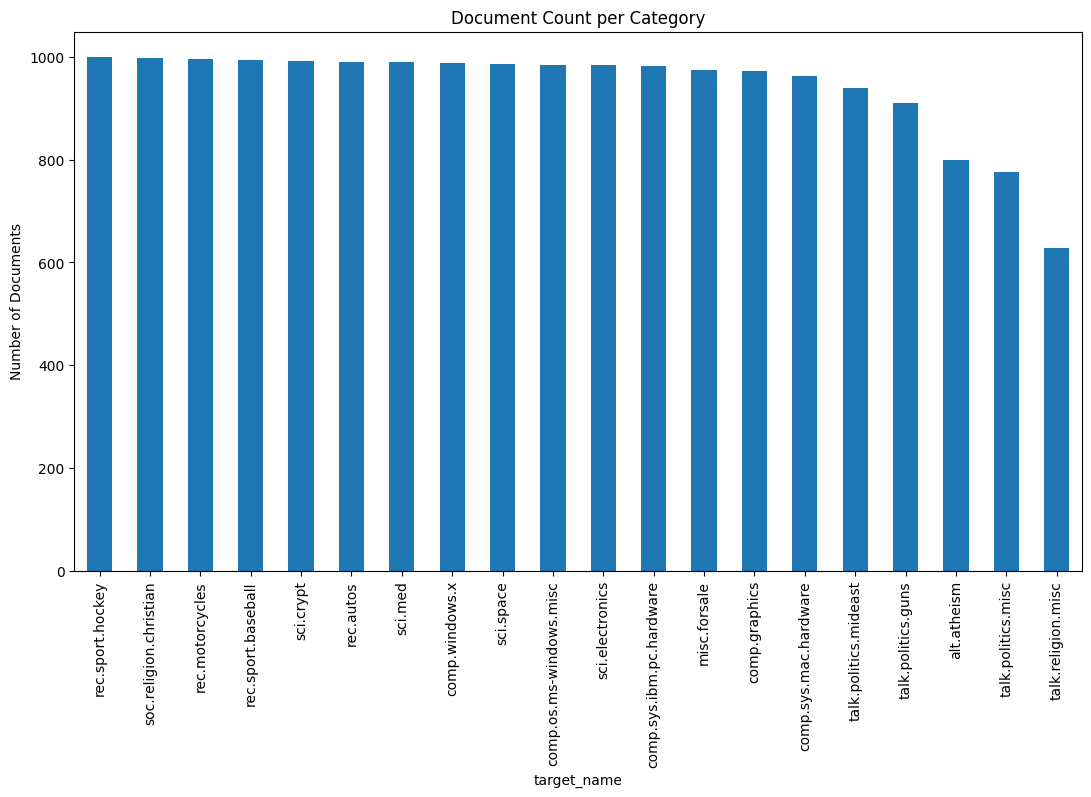

In [5]:
df['target_name'].value_counts().plot(kind='bar', figsize=(13,7))
plt.ylabel('Number of Documents')
plt.title('Document Count per Category')
plt.show()

In [6]:
def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # remove non-letters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [7]:
df['clean_text'] = df['text'].apply(clean_text)
df.head()

,text,target,target_name,clean_text
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey,from mamatha devineni ratnam subject pens fans...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware,from mblawsonmidwayecnuoknoredu matthew b laws...
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast,from hilmierdsvsuse hilmi eren subject re arme...
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware,from guydaustinibmcom guy dawson subject re id...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware,from alexander samuel mcdiarmid subject driver...


In [8]:
X = df['clean_text']
y = df['target_name']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# max_features=5000

- What it does:
- Limits the maximum number of features (columns) in the TF-IDF matrix to the top 5000 words/terms by frequency across the training set.
- Essentially, your model will only “see” the 5000 most important words instead of every single word in the dataset.


# ngram_range=(1,2)

- What it does:
- Controls which n-grams are included as features:
- 1 → unigrams (single words, e.g., “space”)
- 2 → bigrams (pairs of consecutive words, e.g., “space shuttle”)
- (1,2) means include both unigrams and bigrams.

# Why unigrams + bigrams?

- Unigrams capture individual keywords.
- Bigrams capture short phrases that are important for context (e.g., “computer graphics” vs. just “computer” and “graphics”).
- Gives the model more discriminative power without blowing up feature size too much.

In [9]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # unigram + bigram
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [10]:
# Initialize the model
nb_model = MultinomialNB()

# Train on TF-IDF features
nb_model.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [11]:
y_pred = nb_model.predict(X_test_tfidf)

# nb_model.feature_log_prob_[i] → log probabilities of each word for category i
# np.argsort(...)[-10:] → indices of top 10 most predictive words
# feature_names[top10] → actual words

In [20]:
# Map TF-IDF feature indices to words
feature_names = np.array(tfidf.get_feature_names_out())

for i, category in enumerate(nb_model.classes_):
    top10 = np.argsort(nb_model.feature_log_prob_[i])[-10:]
    print(f"Top words for {category}: {feature_names[top10]}")

Top words for alt.atheism: ['not' 'it' 'you' 'and' 'in' 'that' 'is' 'to' 'of' 'the']
Top words for comp.graphics: ['from' 'it' 'in' 'graphics' 'is' 'for' 'and' 'of' 'to' 'the']
Top words for comp.os.ms-windows.misc: ['file' 'for' 'in' 'it' 'is' 'and' 'of' 'to' 'the' 'windows']
Top words for comp.sys.ibm.pc.hardware: ['with' 'for' 'scsi' 'it' 'of' 'drive' 'is' 'and' 'to' 'the']
Top words for comp.sys.mac.hardware: ['in' 'for' 'it' 'apple' 'and' 'is' 'of' 'mac' 'to' 'the']
Top words for comp.windows.x: ['motif' 'it' 'for' 'in' 'is' 'window' 'and' 'of' 'to' 'the']
Top words for misc.forsale: ['from' 'offer' 'shipping' 'to' 'of' 'and' 'the' 'for' 'for sale' 'sale']
Top words for rec.autos: ['that' 'you' 'it' 'is' 'of' 'in' 'and' 'to' 'car' 'the']
Top words for rec.motorcycles: ['my' 'it' 'you' 'dod' 'in' 'of' 'and' 'bike' 'to' 'the']
Top words for rec.sport.baseball: ['game' 'baseball' 'that' 'is' 'he' 'and' 'of' 'in' 'to' 'the']
Top words for rec.sport.hockey: ['is' 'he' 'team' 'hockey' '

In [17]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy:.4f}")

# Classification report
print(classification_report(y_test, y_pred))

Naive Bayes Accuracy: 0.8167
                          precision    recall  f1-score   support

             alt.atheism       0.76      0.69      0.72       160
           comp.graphics       0.63      0.74      0.68       195
 comp.os.ms-windows.misc       0.77      0.77      0.77       197
comp.sys.ibm.pc.hardware       0.73      0.74      0.74       196
   comp.sys.mac.hardware       0.85      0.78      0.81       193
          comp.windows.x       0.83      0.87      0.85       198
            misc.forsale       0.82      0.86      0.84       195
               rec.autos       0.81      0.86      0.84       198
         rec.motorcycles       0.88      0.86      0.87       199
      rec.sport.baseball       0.91      0.88      0.89       199
        rec.sport.hockey       0.91      0.96      0.94       200
               sci.crypt       0.94      0.92      0.93       198
         sci.electronics       0.82      0.79      0.80       197
                 sci.med       0.89      0.86 

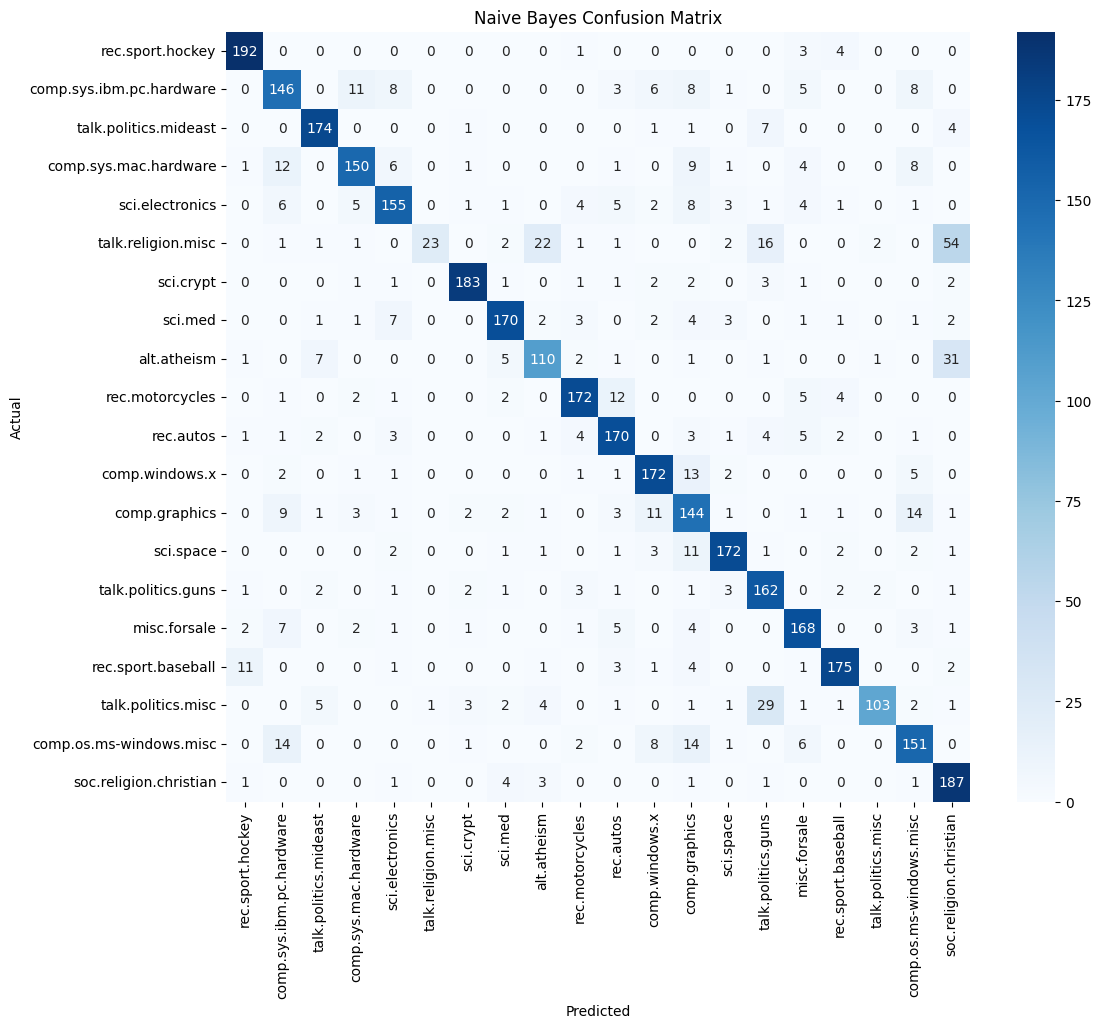

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=df['target_name'].unique())
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=df['target_name'].unique(),
            yticklabels=df['target_name'].unique(), cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# Naive Bayes achieves F1-score of 0.8 on 20-category classification, which is solid for a simple model

In [22]:
# Macro: treats all classes equally
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Micro: global average, good for overall performance
micro_f1 = f1_score(y_test, y_pred, average='micro')

# Weighted: accounts for class imbalance
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}, Micro F1: {micro_f1:.4f}, Weighted F1: {weighted_f1:.4f}")

Macro F1: 0.8003, Micro F1: 0.8167, Weighted F1: 0.8106


# Log loss of 1.03 indicates the model is moderately confident in its predictions, and there is room for improvement with more sophisticated models

In [12]:
y_prob = nb_model.predict_proba(X_test_tfidf)
logloss = log_loss(y_test, y_prob, labels=nb_model.classes_)
print(f"Log Loss: {logloss:.4f}")

Log Loss: 1.0315


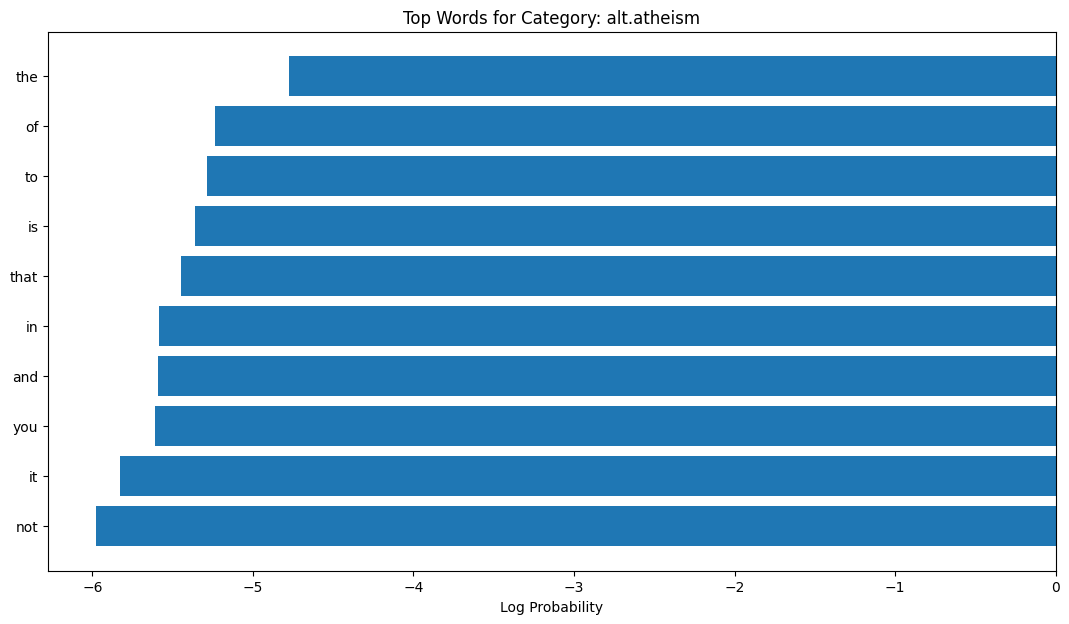

In [25]:
category = 'alt.atheism'  # example category
i = list(nb_model.classes_).index(category)
top10 = np.argsort(nb_model.feature_log_prob_[i])[-10:]
top_words = np.array(tfidf.get_feature_names_out())[top10]
top_probs = nb_model.feature_log_prob_[i][top10]

plt.figure(figsize=(13,7))
plt.barh(top_words, top_probs)
plt.xlabel('Log Probability')
plt.title(f'Top Words for Category: {category}')
plt.show()

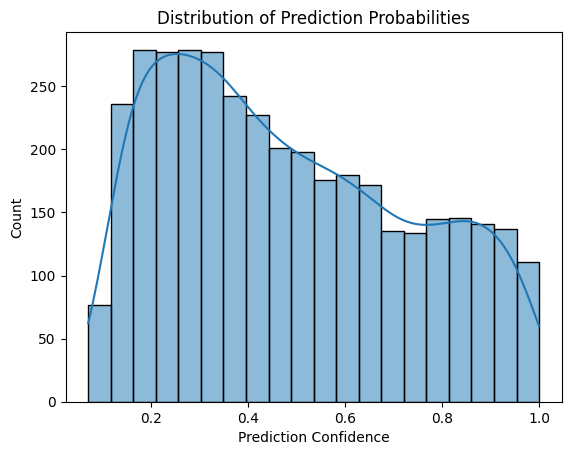

In [28]:
y_prob_max = np.max(nb_model.predict_proba(X_test_tfidf), axis=1)
sns.histplot(y_prob_max, bins=20, kde=True)
plt.xlabel('Prediction Confidence')
plt.title('Distribution of Prediction Probabilities')
plt.show()

In [13]:
lb = LabelBinarizer()
y_true_oh = lb.fit_transform(y_test)

# If binary, ensure shape (n_samples, n_classes)
if y_true_oh.shape[1] == 1:
    y_true_oh = np.hstack([1 - y_true_oh, y_true_oh])

# Residuals
residuals_nb = y_true_oh - y_prob

In [14]:
max_residual_nb = np.max(np.abs(residuals_nb), axis=1)

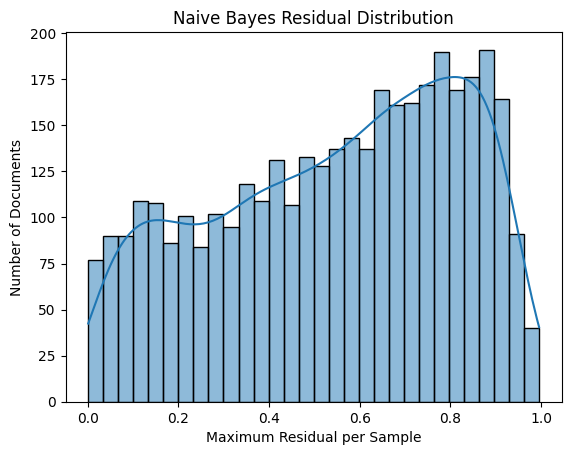

In [15]:
sns.histplot(max_residual_nb, bins=30, kde=True)
plt.xlabel("Maximum Residual per Sample")
plt.ylabel("Number of Documents")
plt.title("Naive Bayes Residual Distribution")
plt.show()

In [16]:
# Average residual per class
residual_per_class_nb = np.mean(np.abs(residuals_nb), axis=0)

for cls, res in zip(lb.classes_, residual_per_class_nb):
    print(f"{cls}: Average residual = {res:.3f}")

alt.atheism: Average residual = 0.053
comp.graphics: Average residual = 0.071
comp.os.ms-windows.misc: Average residual = 0.069
comp.sys.ibm.pc.hardware: Average residual = 0.069
comp.sys.mac.hardware: Average residual = 0.063
comp.windows.x: Average residual = 0.058
misc.forsale: Average residual = 0.041
rec.autos: Average residual = 0.065
rec.motorcycles: Average residual = 0.058
rec.sport.baseball: Average residual = 0.051
rec.sport.hockey: Average residual = 0.037
sci.crypt: Average residual = 0.040
sci.electronics: Average residual = 0.071
sci.med: Average residual = 0.058
sci.space: Average residual = 0.051
soc.religion.christian: Average residual = 0.053
talk.politics.guns: Average residual = 0.053
talk.politics.mideast: Average residual = 0.036
talk.politics.misc: Average residual = 0.050
talk.religion.misc: Average residual = 0.045


In [17]:
top_errors_idx = np.argsort(np.max(np.abs(residuals_nb), axis=1))[-10:]

# Use positional indexing
for i in top_errors_idx:
    print(f"True: {y_test.iloc[i]}, Predicted probs: {y_prob[i]}, Max residual: {max_residual_nb[i]:.3f}")

True: rec.sport.baseball, Predicted probs: [0.00312528 0.0889625  0.13080878 0.10318817 0.12990796 0.08983884
 0.04601251 0.09255552 0.0293921  0.01500041 0.01158992 0.02053334
 0.16718903 0.0351589  0.01265522 0.00597699 0.00715046 0.00199408
 0.00543164 0.00352832], Max residual: 0.985
True: talk.religion.misc, Predicted probs: [7.60886107e-03 6.69770974e-04 7.45120320e-04 5.49939386e-04
 1.28132939e-03 5.19904677e-04 1.59746808e-04 7.12612720e-03
 4.28024121e-03 1.18353449e-03 8.61091630e-04 4.60202932e-02
 3.16023666e-03 7.05122184e-03 2.82527038e-03 6.75804998e-03
 7.93406989e-01 1.36896859e-02 8.88390409e-02 1.32635454e-02], Max residual: 0.987
True: rec.motorcycles, Predicted probs: [0.00383555 0.07994902 0.07676764 0.30724741 0.15911555 0.03584727
 0.16088056 0.05238069 0.01232306 0.01887043 0.00884898 0.00193649
 0.04056551 0.01051487 0.00699033 0.0014713  0.00448385 0.00428513
 0.00950428 0.00418208], Max residual: 0.988
True: talk.politics.guns, Predicted probs: [9.72219592e

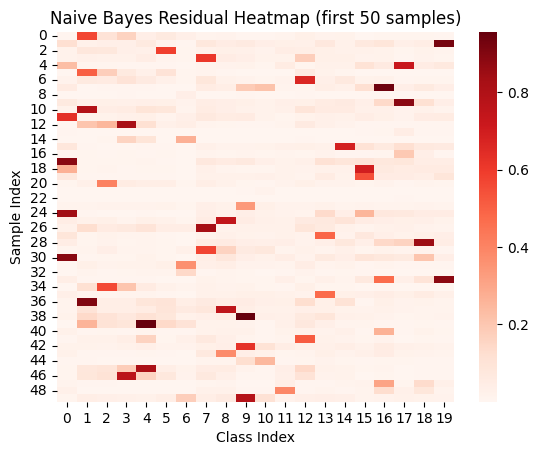

In [18]:
sns.heatmap(np.abs(residuals_nb[:50]), cmap='Reds', annot=False)
plt.xlabel("Class Index")
plt.ylabel("Sample Index")
plt.title("Naive Bayes Residual Heatmap (first 50 samples)")
plt.show()